## Importar las librerias para análisis de data

In [1]:
import numpy as np                                    ## sirve para manipular arrays, calcular media y desviacion estandar
import pandas as pd                                   ## sirve para manipular dataframes
import xgboost as xgb                                 ## Libreria para utilizar el modelo xgboost
from sklearn.impute import SimpleImputer              ## Sirve para imputar los valores
from sklearn.pipeline import Pipeline                 ## 
from sklearn.preprocessing import OneHotEncoder       ## Sirve para codificar los valores de las variables categoricas
from sklearn.preprocessing import StandardScaler      ## Sirve para el estandarizar variables numericas
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split  ## Sirve para dividir el los datos entre train y test
from sklearn.model_selection import GridSearchCV      ## mejora de los parametros de xgboost
from sklearn.metrics import accuracy_score            ## Sirve para utilizar la metrica de accuracy
from sklearn.metrics import classification_report     ## Sirve para las metricas de precision, recall, f1 score
from sklearn.metrics import confusion_matrix          ## Sirve para crear una matriz de confusion
from sklearn.metrics import plot_confusion_matrix      ## Dibuja la matriz de confusion
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer ## metricas para medir el desempeño

## Carga, cleaning y preprocesamiento del dataset

In [2]:
## Cargar el dataset del archivo CSV a un dataframe

insurance_claims = pd.read_csv('Dataset/insurance_claims.csv')

In [3]:
## Mostrar la cabecera del dataframe para comprobar si cargó correctamente la informacion

insurance_claims.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,10/17/2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,6/27/2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,9/6/2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,5/25/1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [4]:
## Se eliminan las variables insured_zip, policy_number, incident_date, incident_location, auto_model dado que no aportan informacion relevante al proposito del proyecto

insurance_claims = insurance_claims.drop(['insured_zip', 'policy_number', 'incident_date', 'incident_location', 'auto_model', 'policy_bind_date', 'capital-gains', 'capital-loss', 'policy_csl'], axis = 1)

In [5]:
## Revisar el tamaño del dataset

insurance_claims.shape

(1000, 30)

In [6]:
## Reemplazar los espacios que tienen algunos valores dentro de las variables insured_education_level, incident_type, collision_type, incident_severity

insurance_claims.replace(' ', '_', regex = True, inplace = True)

## Reemplazar las - que tienen algunos valores dentro de las variables insured_occupation, insured_hobbies, insured_relationship, incident_type

insurance_claims.replace('-', '_', regex = True, inplace = True)

## Reemplazar los - de los titulos de las variables capital-gains, capital-loss

insurance_claims.columns = insurance_claims.columns.str.replace('-', '_')

## Reemplazar los valores ? que tienen algunos valores dentro de las variables property_damage, police_report_available

insurance_claims['property_damage'] = insurance_claims['property_damage'].replace({'?': np.nan})
insurance_claims['police_report_available'] = insurance_claims['police_report_available'].replace({'?': np.nan})
insurance_claims['collision_type'] = insurance_claims['collision_type'].replace({'?': np.nan})

In [7]:
## Reemplazar los valores de la variable respuesta por 0 y 1

insurance_claims['fraud_reported'].replace('Y', '1', regex = True, inplace = True)
insurance_claims['fraud_reported'].replace('N', '0', regex = True, inplace = True)

In [8]:
## Obtener el tipo de dato de cada variable y la totalidad de las entradas

insurance_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   object 
 3   policy_deductable            1000 non-null   int64  
 4   policy_annual_premium        1000 non-null   float64
 5   umbrella_limit               1000 non-null   int64  
 6   insured_sex                  1000 non-null   object 
 7   insured_education_level      1000 non-null   object 
 8   insured_occupation           1000 non-null   object 
 9   insured_hobbies              1000 non-null   object 
 10  insured_relationship         1000 non-null   object 
 11  incident_type                1000 non-null   object 
 12  collision_type               822 non-null    object 
 13  incident_severity  

In [9]:
## revisar si existen datos faltantes dentro del dataframe

insurance_claims.isnull().sum()

months_as_customer               0
age                              0
policy_state                     0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_hobbies                  0
insured_relationship             0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted            0
incident_state                   0
incident_city                    0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                360
bodily_injuries                  0
witnesses                        0
police_report_available        343
total_claim_amount               0
injury_claim                     0
property_claim                   0
vehicle_claim                    0
auto_make                        0
auto_year           

In [10]:
## Dividir el dataset entre features (X) y target (Y)

x = insurance_claims.drop("fraud_reported", axis = 1)
y = insurance_claims.fraud_reported

In [11]:
## Dividir features (X) entre variables categoricas y cuantitativas para su uso en el modelo

#cat_cols = x.loc[:,[policy_state, policy_csl, insured_sex, insured_education_level, insured_occupation, insured_hobbies, insured_relationship, incident_type, collision_type, incident_severity, authorities_contacted, incident_state, incident_city, property_damage, police_report_available, auto_make]]
#num_cols = x.loc[:,[months_as_customer, age, policy_deductable, policy_annual_premium, umbrella_limit, capital-gains, capital-loss, incident_hour_of_the_day, number_of_vehicles_involved, bodily_injuries, witnesses, total_claim_amount, injury_claim, property_claim, vehicle_claim, auto_year]]

cat_cols = x.select_dtypes(exclude="number").columns
num_cols = x.select_dtypes(include="number").columns

print(cat_cols)
print(num_cols)

Index(['policy_state', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'property_damage', 'police_report_available', 'auto_make'],
      dtype='object')
Index(['months_as_customer', 'age', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_year'],
      dtype='object')


In [12]:
## Codigo para codificar las variables categoricas e imputar valores faltantes mediante la tecnica del valor mas frecuente para esa variable, a pesar de que no hayan valores faltantes, se dejara este codigo como referencia para un futuro

# Construccion del pipeline
categorical_pipeline = Pipeline(
     steps = [
         ("impute", SimpleImputer(strategy = "most_frequent")),
         ("oh-encode", OneHotEncoder(handle_unknown = "ignore", sparse = False))
             ]
)

In [13]:
## Codigo para estandarizar las variables numericas e imputar valores faltantes mediante el uso de la media

# Construccion del pipeline
numeric_pipeline = Pipeline(
    steps = [("impute", SimpleImputer(strategy = "mean")),
             ("scale", StandardScaler())
            ]
)

In [14]:
## Finalmente se combinan los anteriores pipelines con un column transformer, y pasamos por este las variables categoricas y numericas

full_processor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols)
                  ]
)

## Entrenamiento del modelo con XGBoost

In [35]:
## Preproceso de los datos

x_processed = full_processor.fit_transform(x)
y_processed = SimpleImputer(strategy = "most_frequent").fit_transform(y.values.reshape(-1,1))

In [36]:
## Division de los mismos entre training y test

x_train, x_test, y_train, y_test = train_test_split(x_processed, y_processed, stratify = y_processed, random_state = 42)

In [37]:
## Ahora corremos el modelo con los parametros que tiene por defecto

# Inicializar el classifier (init classifier)
xgb_cl = xgb.XGBClassifier(objective = 'binary:logistic', missing = np.nan, seed = 42, subsample = 0.9, colsample_bytree = 0.8)

# Ajustar (fit)
xgb_cl.fit(x_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(x_test, y_test)])

# Predecir (predict)
preds = xgb_cl.predict(x_test)

[0]	validation_0-aucpr:0.58307
[1]	validation_0-aucpr:0.57369
[2]	validation_0-aucpr:0.59086
[3]	validation_0-aucpr:0.63196
[4]	validation_0-aucpr:0.64224
[5]	validation_0-aucpr:0.64079
[6]	validation_0-aucpr:0.63746
[7]	validation_0-aucpr:0.65391
[8]	validation_0-aucpr:0.64947
[9]	validation_0-aucpr:0.63952
[10]	validation_0-aucpr:0.62321
[11]	validation_0-aucpr:0.63863
[12]	validation_0-aucpr:0.64469
[13]	validation_0-aucpr:0.63091
[14]	validation_0-aucpr:0.63783
[15]	validation_0-aucpr:0.63479
[16]	validation_0-aucpr:0.63769
[17]	validation_0-aucpr:0.61779


C:\Users\afinf\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\afinf\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [38]:
# Mostrar el accuracy score para este test
print(' ')
print('METRICAS DE EVALUACION')
print(' ')
print('* Accuracy score -- > {:.2f}'.format(accuracy_score(y_test, preds)))
print(' ')
print('* Matriz de confusion')
print(confusion_matrix(y_test, preds))
print(' ')
print('* Precision, recall, f1 score ')
print(classification_report(y_test, preds))

 
METRICAS DE EVALUACION
 
* Accuracy score -- > 0.83
 
* Matriz de confusion
[[166  22]
 [ 20  42]]
 
* Precision, recall, f1 score 
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       188
           1       0.66      0.68      0.67        62

    accuracy                           0.83       250
   macro avg       0.77      0.78      0.78       250
weighted avg       0.83      0.83      0.83       250



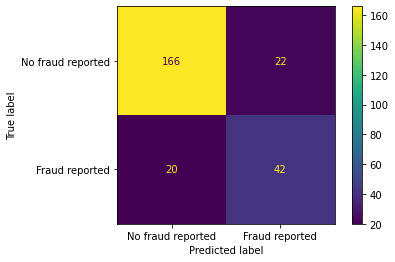

In [39]:
## Grafica de la confusion matrix

plot_confusion_matrix(xgb_cl, x_test, y_test, values_format = 'd', display_labels = ['No fraud reported', 'Fraud reported'])

### Optimizacion de los parametros del modelo de XGBoost

In [41]:
## Se realiza la optimizacion de los hiperparametros mediante la funcion GridSearchCV(), se realizara en 2 rondas

## primera ronda ronda
# Set nuestros parametros max_depth, learning_rate, gamma, reg_lambda, scale_pos_weight (recomendados de ajustar para dataset con imbalance data) de la siguiente manera
param_grid = {
    'max_depth': [5, 6, 7],                 ## obtenemos arboles que son de 3, 4 o 5 niveles en su clasificacion
    'learning_rate': [0.01, 0.05 ,0.1],     
    'gamma': [2, 3, 4],
    'reg_lambda': [0.01, 0.1 , 0.5],
    'scale_pos_weight': [2, 3, 4]
}

# Optimizacion mediante GridSearchCV(). Para prevenir over-fitting solo se usa un random subset del 90% y el 80% de las columnas
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic', seed = 42, subsample = 0.9, colsample_bytree = 0.8),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose = 0,
    n_jobs = 10,
    cv = 3
)

In [42]:
## Ahora evaluamos los parametros para ver cuales optimizan mejor nuestro modelo

# Ajustar (fit)
optimal_params.fit(x_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(x_test, y_test)])

print(optimal_params.best_params_)

[0]	validation_0-aucpr:0.61412
[1]	validation_0-aucpr:0.58797
[2]	validation_0-aucpr:0.59200
[3]	validation_0-aucpr:0.57668
[4]	validation_0-aucpr:0.58474
[5]	validation_0-aucpr:0.56537
[6]	validation_0-aucpr:0.58360
[7]	validation_0-aucpr:0.59472
[8]	validation_0-aucpr:0.59793
[9]	validation_0-aucpr:0.60476
[10]	validation_0-aucpr:0.60952
{'gamma': 3, 'learning_rate': 0.01, 'max_depth': 6, 'reg_lambda': 0.1, 'scale_pos_weight': 2}


C:\Users\afinf\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\afinf\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [43]:
## Se realiza la optimizacion de los hiperparametros mediante la funcion GridSearchCV(), se realizara en 2 rondas

## primera ronda ronda
# Set nuestros parametros max_depth, learning_rate, gamma, reg_lambda, scale_pos_weight (recomendados de ajustar para dataset con imbalance data) de la siguiente manera
param_grid = {
    'max_depth': [6],                 ## obtenemos arboles que son de 3, 4 o 5 niveles en su clasificacion
    'learning_rate': [0.001, 0.01, 0.05],     
    'gamma': [3],
    'reg_lambda': [0.1],
    'scale_pos_weight': [1, 2, 3]
}

# Optimizacion mediante GridSearchCV(). Para prevenir over-fitting solo se usa un random subset del 90% y el 80% de las columnas
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic', seed = 42, subsample = 0.9, colsample_bytree = 0.8),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose = 0,
    n_jobs = 10,
    cv = 3
)

In [44]:
## Ahora evaluamos los parametros para ver cuales optimizan mejor nuestro modelo

# Ajustar (fit)
optimal_params.fit(x_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'auc', eval_set = [(x_test, y_test)])

print(optimal_params.best_params_)

[0]	validation_0-auc:0.82048
[1]	validation_0-auc:0.82387
[2]	validation_0-auc:0.83116
[3]	validation_0-auc:0.82177
[4]	validation_0-auc:0.82683
[5]	validation_0-auc:0.82305
[6]	validation_0-auc:0.84313
[7]	validation_0-auc:0.84240
[8]	validation_0-auc:0.83820
[9]	validation_0-auc:0.83961
[10]	validation_0-auc:0.84098
[11]	validation_0-auc:0.84128
[12]	validation_0-auc:0.84279
[13]	validation_0-auc:0.83391
[14]	validation_0-auc:0.83820
[15]	validation_0-auc:0.83811
{'gamma': 3, 'learning_rate': 0.01, 'max_depth': 6, 'reg_lambda': 0.1, 'scale_pos_weight': 2}


C:\Users\afinf\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\afinf\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Construccion del modelo utilizando los mejores parametros

In [45]:
## Ahora corremos el modelo con los parametros que se acaban de optimizar

# Inicializar el classifier (init classifier)
xgb_cl_opt = xgb.XGBClassifier(objective = 'binary:logistic', missing = np.nan, seed = 42, gamma = 3 , learning_rate = 0.01, max_depth = 6, reg_lambda = 0.1, scale_pos_weight = 2, subsample = 0.9, colsample_bytree = 0.8)

# Ajustar (fit)
xgb_cl_opt.fit(x_train, y_train, verbose = True, early_stopping_rounds = 10, eval_metric = 'aucpr', eval_set = [(x_test, y_test)])

# Predecir (predict)
preds = xgb_cl_opt.predict(x_test)

[0]	validation_0-aucpr:0.61412
[1]	validation_0-aucpr:0.58797
[2]	validation_0-aucpr:0.59200
[3]	validation_0-aucpr:0.57668
[4]	validation_0-aucpr:0.58474
[5]	validation_0-aucpr:0.56537
[6]	validation_0-aucpr:0.58360
[7]	validation_0-aucpr:0.59472
[8]	validation_0-aucpr:0.59793
[9]	validation_0-aucpr:0.60476
[10]	validation_0-aucpr:0.60952


In [46]:
# Mostrar el accuracy score para este test
print(' ')
print('METRICAS DE EVALUACION')
print(' ')
print('* Accuracy score -- > {:.2f}'.format(accuracy_score(y_test, preds)))
print(' ')
print('* Matriz de confusion')
print(confusion_matrix(y_test, preds))
print(' ')
print('* Precision, recall, f1 score ')
print(classification_report(y_test, preds))

 
METRICAS DE EVALUACION
 
* Accuracy score -- > 0.80
 
* Matriz de confusion
[[152  36]
 [ 14  48]]
 
* Precision, recall, f1 score 
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       188
           1       0.57      0.77      0.66        62

    accuracy                           0.80       250
   macro avg       0.74      0.79      0.76       250
weighted avg       0.83      0.80      0.81       250



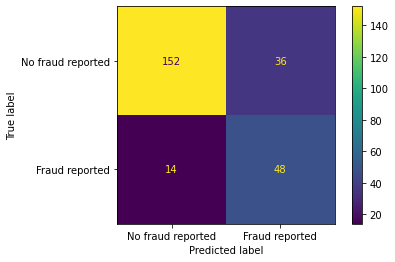

In [47]:
## Grafica de la confusion matrix

plot_confusion_matrix(xgb_cl_opt, x_test, y_test, values_format = 'd', display_labels = ['No fraud reported', 'Fraud reported'])

Como se observa mediante la confusion matrix, al optimizar los parametros de XGBoost para nuestro modelo por medio de GridSearchCV; se observa una mejoría significativa en la clasificación que realiza nuestro modelo en los casos en donde se cometió fraude, es decir donde la label es 1, pasando de tener un recall de 68% con los parametros de default a un recall de 77% para la clasificación de los casos fraudulentos. Esto es bastante positivo, pues a pesar de que ahora el modelo comete más errores en la clasificación de casos donde no se cometió fraude, incrementó sus true positives para las predicciones que hizo del label.

Para obtener dicha mejoría, se utilizaron los parámetros de 'gamma': 3, 'learning_rate': 0.01, 'max_depth': 6, 'reg_lambda': 0.1, 'scale_pos_weight': 2, los cuales fueron los valores intermedios que introdujimos en el GridSearch, indicandonos, de este modo que los valores óptimos se encuentran muy cercanos a estos, y que no varían por encima ni por debajo de los mismos.